In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import seaborn as sns
from collections import defaultdict, Counter
import os

#sns.set_style("whitegrid", {"axes.facecolor": "oldlace"})
sns.set_context("poster")

In [2]:
from communotron import *

In [3]:
def det_sex(strain):
    if strain == 'C':
        if np.random.random() < 0.5:
            return 'M'
        else:
            return 'F'
    else:
        return 'H'

In [5]:
fec_df = pd.read_csv('./summ_fec.csv', index_col=0)
C_fec_raw = [12.53, 22.8, 24.39, 22.32, 25.78, 22.7, 20.87, 21.36, 17.75, 10.44, 10.04, 10.81, 12.82, np.mean([12.82, 4.78]), 4.78, np.mean([4.78, 2.22]),  2.22]
C_fec = [int(round(x)) for x in C_fec_raw]
A_fec = list(fec_df[(fec_df['Species']=='P. pacificus') & (fec_df['Strain'] == 'RSO011')]['mean'])
B_fec = list(fec_df[(fec_df['Species']=='P. mayeri') & (fec_df['Strain'] == 'RSO012')]['mean'])

In [12]:
# pPred=0.005

pPred=0.005
mStep=10
period=300
Tsim=1000
Tlim=1000


grid_size=101
source_center = (grid_size//2, grid_size//2)  # Center of the source
source_diameter = grid_size//5  # Diameter of the source
decline_rate = 0.3  # Rate of decline
comm = Community(grid_size, source_center, source_diameter, decline_rate, resource_cycle=period, pred_par_b=pPred, time_lim=Tlim)
mf_probs = {'A': 1.0, 'B': 0.0, 'C': 0.0}
dev_pars = {'A': {0: 48, 1:72, 4:72, 5:24}, 'B':{0: 48, 1:96, 4:96, 5:24}, 'C':{0: 48, 1:120, 4:24, 5:24}}
surv_prs = {2: 500, 4: 1000, 5: 1000}
fec_data = {'A': A_fec, 'B':B_fec, 'C':C_fec}
age_lim = {'A' : 120, 'B': 120, 'C': 408}

comm.add_features(mf_probs, dev_pars, surv_prs, fec_data, age_lim)
nA = 1
nB = 0
nC = 0
strains = np.array(['A' for i in range(nA)] + ['B' for i in range(nB)] + ['C' for i in range(nC)])
age = np.zeros(len(strains)) 
dev_state = np.ones(len(strains)) * 4 
mf_state = np.array([np.random.binomial(1, mf_probs[x]) for x in strains])
sex = np.array([det_sex(x) for x in strains])
comm.set_max_steps(mStep)
comm.add_strains(strains, dev_state, mf_state, age, sex)

t_sim = 1000
comm.initialize_history()
for _ in tqdm(range(t_sim)):
        comm.random_walk()
        # comm.reproduce()
        # comm.update_dev_state()
        # comm.update_mf_state()
        # comm.update_survival()
        # comm.remove_old_fec()
        # comm.increase_age()
        comm.increase_time()
        comm.update_history()

100%|██████████| 1000/1000 [00:13<00:00, 74.35it/s]


In [45]:
comm.history

,E,J,A,Dead,Dauer,AJ,fE,fJ,fA,fDead,fDauer,fAJ,killed,cum_migrated,cum_migrated_f,Strain,Time,Resource
0,0,0,0,0,100,0,0.0,0.0,0.000000,0,0.833333,0.000000,0,0,0.000000,A,0,0.00000
0,0,0,0,0,10,0,0.0,0.0,0.000000,0,0.083333,0.000000,0,0,0.000000,B,0,0.00000
0,0,0,0,0,10,0,0.0,0.0,0.000000,0,0.083333,0.000000,0,0,0.000000,C,0,0.00000
0,0,0,0,0,100,0,0.0,0.0,0.000000,0,0.833333,0.000000,0,0,0.000000,A,1,0.00011
0,0,0,0,0,10,0,0.0,0.0,0.000000,0,0.083333,0.000000,0,0,0.000000,B,1,0.00011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,0,5,0,4,1,0.0,0.0,0.014493,0,0.000770,0.000035,0,2,0.009804,B,499,0.00000
0,27,0,3,0,2,129,1.0,0.0,0.008696,0,0.000385,0.004513,0,3,0.014706,C,499,0.00000
0,0,0,337,0,5185,28451,0.0,0.0,0.976812,0,0.998844,0.995382,0,200,0.975610,A,500,0.00000
0,0,0,5,0,4,1,0.0,0.0,0.014493,0,0.000771,0.000035,0,2,0.009756,B,500,0.00000


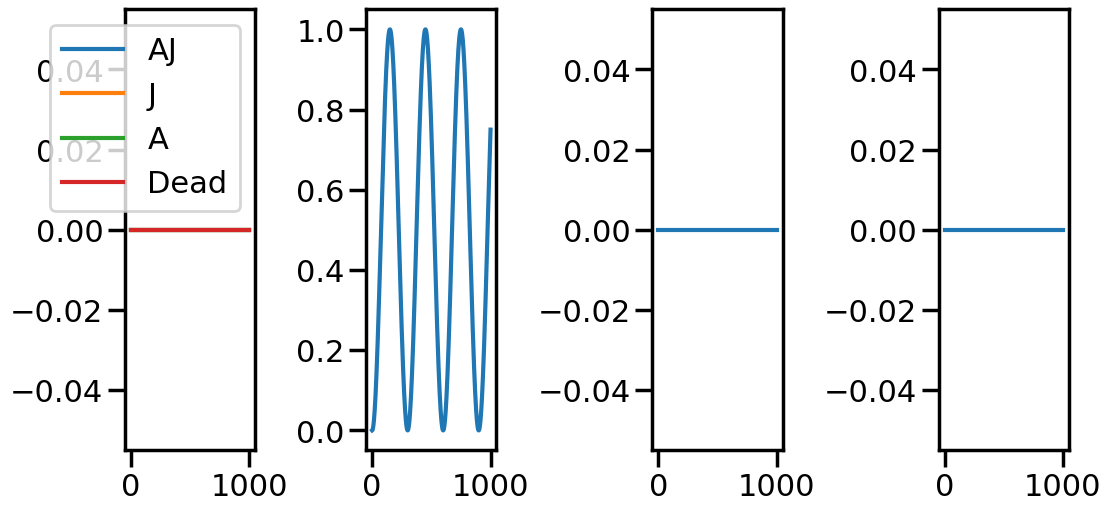

In [13]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(11, 5),constrained_layout=True)

axes = axes.flatten()

for i in ['AJ', 'J', 'A', 'Dead']:

    axes[0].plot(comm.history[comm.history["Strain"]=="A"]['Time'], comm.history[comm.history["Strain"]=="C"][i], label=i)

axes[0].legend()

axes[1].plot(comm.history[comm.history["Strain"]=="A"]['Time'], comm.history[comm.history["Strain"]=="A"]['Resource'])

axes[2].plot(comm.history[comm.history["Strain"]=="C"]['Time'], comm.history[comm.history["Strain"]=="B"]['killed'])

axes[3].plot(comm.history[comm.history["Strain"]=="C"]['Time'], comm.history[comm.history["Strain"]=="C"]['killed'])

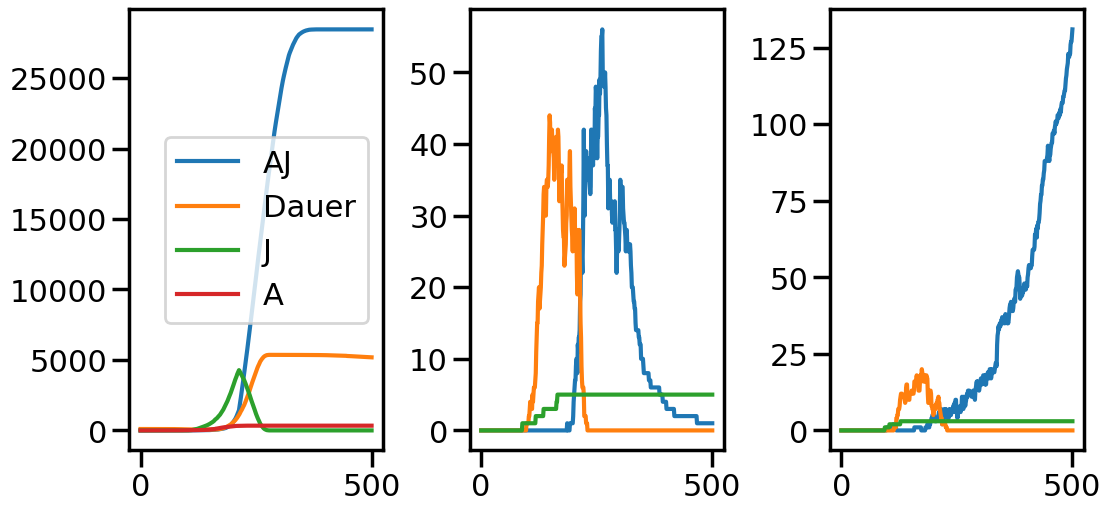

In [48]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(11, 5),constrained_layout=True)

axes = axes.flatten()

for i in ['AJ', 'Dauer', 'J', 'A']:

    axes[0].plot(comm.history[comm.history["Strain"]=="A"]['Time'], comm.history[comm.history["Strain"]=="A"][i], label=i)

for i in ['AJ', 'J', 'A']:

    axes[1].plot(comm.history[comm.history["Strain"]=="A"]['Time'], comm.history[comm.history["Strain"]=="B"][i], label=i)

for i in ['AJ', 'J', 'A']:

    axes[2].plot(comm.history[comm.history["Strain"]=="A"]['Time'], comm.history[comm.history["Strain"]=="C"][i], label=i)

axes[0].legend()

In [47]:
np.sum(comm.history[comm.history["Strain"]=="B"]['killed'] +  comm.history[comm.history["Strain"]=="C"]['killed'])

1092

In [30]:
pPred=0.005
mStep=10
# period=300
# Tsim=1000
# Tlim=300

period=5000
Tsim=1000
Tlim=10


grid_size=101
source_center = (grid_size//2, grid_size//2)  # Center of the source
source_diameter = grid_size//5  # Diameter of the source
decline_rate = 0.3  # Rate of decline
comm = Community(grid_size, source_center, source_diameter, decline_rate, resource_cycle=period, pred_par_b=pPred, time_lim=Tlim)
mf_probs = {'A': 1.0, 'B': 0.0, 'C': 0.0}
dev_pars = {'A': {0: 48, 1:72, 4:72, 5:24}, 'B':{0: 48, 1:96, 4:96, 5:24}, 'C':{0: 48, 1:120, 4:24, 5:24}}
surv_prs = {2: 500, 4: 1000, 5: 1000}
fec_data = {'A': A_fec, 'B':B_fec, 'C':C_fec}
age_lim = {'A' : 120, 'B': 120, 'C': 408}

In [31]:
comm.add_features(mf_probs, dev_pars, surv_prs, fec_data, age_lim)
nA = 100
nB = 0
nC = 0
strains = np.array(['A' for i in range(nA)] + ['B' for i in range(nB)] + ['C' for i in range(nC)])
age = np.zeros(len(strains)) 
dev_state = np.ones(len(strains)) * 5 
mf_state = np.array([np.random.binomial(1, mf_probs[x]) for x in strains])
sex = np.array([det_sex(x) for x in strains])
comm.set_max_steps(mStep)
comm.add_strains(strains, dev_state, mf_state, age, sex)

In [32]:
t_sim = 1000
comm.initialize_history()
for _ in range(t_sim):
        comm.random_walk()
        comm.update_dev_state()
        comm.update_mf_state()
        comm.remove_old_fec()
        comm.increase_age()
        comm.update_survival()
        comm.increase_time()
        comm.update_history()


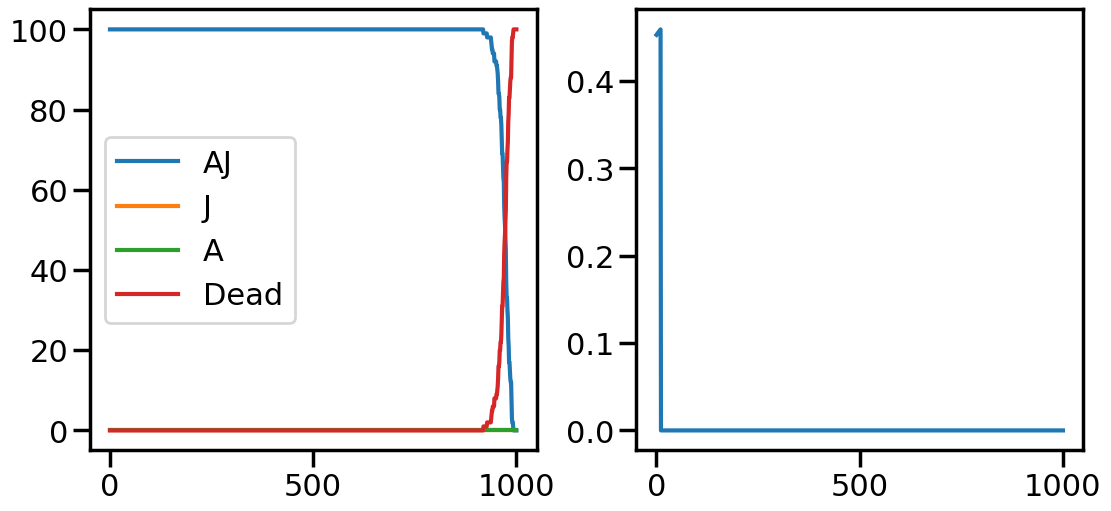

In [33]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(11, 5),constrained_layout=True)

axes = axes.flatten()

for i in ['AJ', 'J', 'A', 'Dead']:

    axes[0].plot(comm.history[comm.history["Strain"]=="A"]['Time'], comm.history[comm.history["Strain"]=="A"][i], label=i)

axes[0].legend()

axes[1].plot(comm.history[comm.history["Strain"]=="A"]['Time'], comm.history[comm.history["Strain"]=="A"]['Resource'])

In [24]:
mStep=0
period=5000
Tsim=1000
Tlim=10
grid_size=101
source_center = (grid_size//2, grid_size//2)  # Center of the source
source_diameter = grid_size//5  # Diameter of the source
decline_rate = 0.3  # Rate of decline
comm = Community(grid_size, source_center, source_diameter, decline_rate, resource_cycle=period, pred_par_b=pPred, time_lim=Tlim)
mf_probs = {'A': 1.0, 'B': 0.0, 'C': 0.0}
dev_pars = {'A': {0: 48, 1:72, 4:72, 5:24}, 'B':{0: 48, 1:96, 4:96, 5:24}, 'C':{0: 48, 1:120, 4:24, 5:24}}
surv_prs = {2: 500, 4: 1000, 5: 1000}
fec_data = {'A': A_fec, 'B':B_fec, 'C':C_fec}
age_lim = {'A' : 120, 'B': 120, 'C': 408}


comm.add_features(mf_probs, dev_pars, surv_prs, fec_data, age_lim)
nA = 100
nB = 0
nC = 0
strains = np.array(['A' for i in range(nA)] + ['B' for i in range(nB)] + ['C' for i in range(nC)])
age = np.zeros(len(strains)) 
dev_state = np.ones(len(strains)) * 4 
mf_state = np.array([np.random.binomial(1, mf_probs[x]) for x in strains])
sex = np.array([det_sex(x) for x in strains])
comm.set_max_steps(mStep)
comm.add_strains(strains, dev_state, mf_state, age, sex)

t_sim = 1000
comm.initialize_history()
for _ in tqdm(range(t_sim)):
        comm.random_walk()
        comm.update_dev_state()
        comm.update_mf_state()
        comm.remove_old_fec()
        comm.increase_age()
        comm.update_survival()
        comm.increase_time()
        comm.update_history()


100%|██████████| 1000/1000 [00:26<00:00, 37.19it/s]


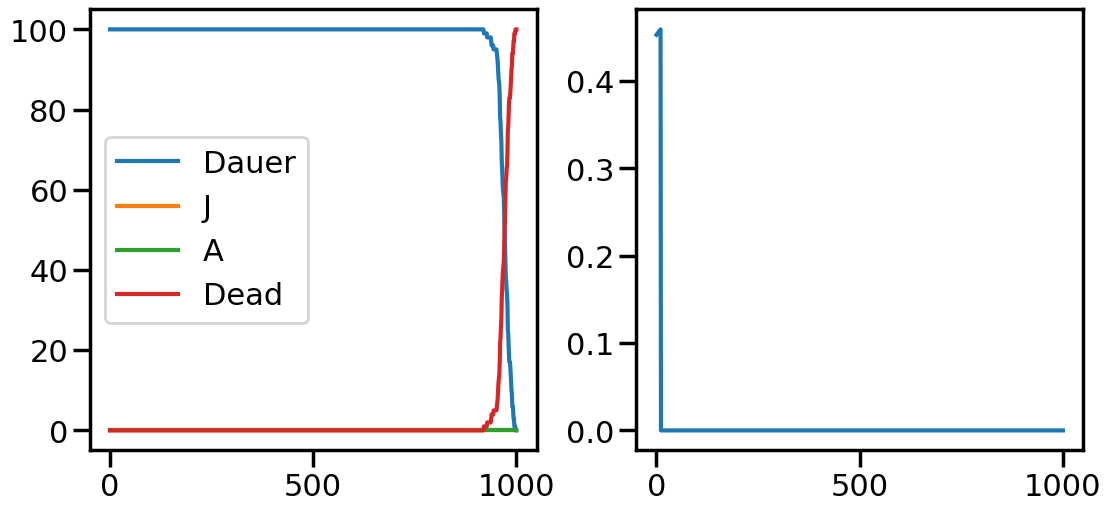

In [25]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(11, 5),constrained_layout=True)

axes = axes.flatten()

for i in ['Dauer', 'J', 'A', 'Dead']:

    axes[0].plot(comm.history[comm.history["Strain"]=="A"]['Time'], comm.history[comm.history["Strain"]=="A"][i], label=i)

axes[0].legend()

axes[1].plot(comm.history[comm.history["Strain"]=="A"]['Time'], comm.history[comm.history["Strain"]=="A"]['Resource'])

In [31]:
comm.history

,E,J,A,Dead,Dauer,AJ,fE,fJ,fA,fDead,fDauer,fAJ,killed,cum_migrated,cum_migrated_f,Strain,Time,Resource
0,0,0,0,0,0,100,0,0.0,0,0.0,0,1.0,0,0,0,A,0,0.000000
0,0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,B,0,0.000000
0,0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,C,0,0.000000
0,0,0,0,0,0,100,0,0.0,0,0.0,0,1.0,0,0,0,A,1,0.000110
0,0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,B,1,0.000110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,B,99,0.740877
0,0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,C,99,0.740877
0,0,1,0,99,0,0,0,1.0,0,1.0,0,0.0,0,0,0,A,100,0.750000
0,0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,B,100,0.750000


<Axes: >

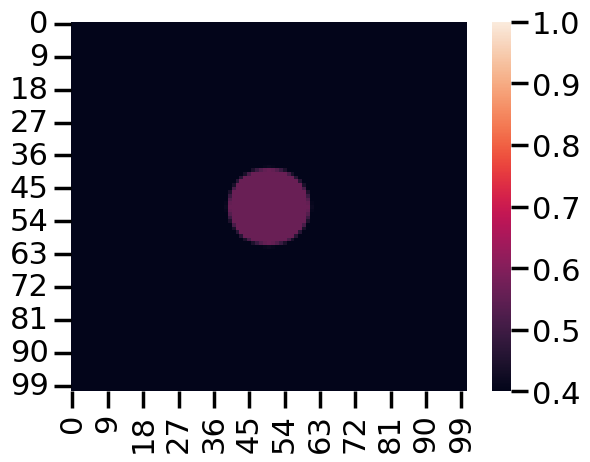

In [23]:
sns.heatmap(comm.current_gradient, vmax=1, vmin=0.4)

In [16]:
comm.simulate(100)

KeyError: 'A'

In [ ]:
comm.add_features(mf_probs, dev_pars, surv_prs, fec_data, age_lim)
nA = np.random.poisson(10)
nB = np.random.poisson(10)
nC = np.random.poisson(10)
strains = np.array(['A' for i in range(nA)] + ['B' for i in range(nB)] + ['C' for i in range(nC)])
age = np.zeros(len(strains)) 
dev_state = np.ones(len(strains)) * 5 
mf_state = np.array([np.random.binomial(1, mf_probs[x]) for x in strains])
sex = np.array([det_sex(x) for x in strains])
comm.set_max_steps(mStep)
comm.add_strains(strains, dev_state, mf_state, age, sex)